In [3]:
import sqlite3
import pandas as pd
import dspy
import dotenv, os
from pydantic import BaseModel, Field
import openai
import pm4py
import ast
from numpy import random
from dspy.evaluate import Evaluate
from collections import defaultdict
import tqdm as notebook_tqdm
import copy
import re
from dspy.teleprompt import BootstrapFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import phoenix as px
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from chroma_retriever import Chroma
from chromadb.utils import embedding_functions

In [4]:
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-mpnet-base-v2")

# 0.Data loading

In [5]:
INPUT_FILE_NAME = "/Users/sulzair/Documents/Bachelor Thesis/Proof-of-Concept/Road_Traffic_Fine_Management_Process.xes" #replce with your file path
SQLITE_DB_NAME = "SQL_big.db" #"my_database.db" #leve as is

In [6]:
phoenix_session = px.launch_app()
endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))

trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [79]:
# configure llm
dotenv.load_dotenv()
lm = dspy.LM('openai/gpt-4o', temperature=0.3, max_tokens=4096, stop=None, cache=False)
dspy.settings.configure(lm = lm, trace = [])

In [ ]:
df = pm4py.read_xes(INPUT_FILE_NAME)
df.columns = df.columns.str.replace(':', '_', regex=False)
# replace nan values with 0 in columns "amount", "expense", "paymentAmount", "totalPaymentAmount"
df['amount'] = df['amount'].fillna(0)
df['expense'] = df['expense'].fillna(0)
df['paymentAmount'] = df['paymentAmount'].fillna(0)
df['totalPaymentAmount'] = df['totalPaymentAmount'].fillna(0)
#fturn euros into cents
df['amount'] = df['amount'] * 100
df['amount'] = df['amount'].astype(int)
df['expense'] = df['expense'] * 100
df['expense'] = df['expense'].astype(int)
df['paymentAmount'] = df['paymentAmount'] * 100
df['paymentAmount'] = df['paymentAmount'].astype(int)
df['totalPaymentAmount'] = df['totalPaymentAmount'] * 100
df['totalPaymentAmount'] = df['totalPaymentAmount'].astype(int)

df_s = df.sort_values(by=["case_concept_name", "time_timestamp"])
df_s = df_s.reset_index(drop=True)

gold = pd.read_csv("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/benchmark/PM_EVALQUESTIONS_DF4.csv")
gold['time_timestamp'] = pd.to_datetime(gold['time_timestamp'])
gold['time_timestamp_beginn'] = pd.to_datetime(gold['time_timestamp_beginn'])
gold['time_timestamp_end'] = pd.to_datetime(gold['time_timestamp_end'])
gold['duration'] = pd.to_timedelta(gold['duration'], unit='s')
#gold["duration"] = gold["duration"].dt.total_seconds()
gold_sorted = gold.sort_values(by=['case_concept_name', 'time_timestamp'])
gold_sorted = gold_sorted.reset_index(drop=True)

# add any columns from gold which are not present in df_s
for col in gold_sorted.columns:
    if col not in df_s.columns:
        df_s[col] = gold_sorted[col]

conn = sqlite3.connect(SQLITE_DB_NAME)
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS temp_table;")
print(cur.fetchall())
conn.commit()
df_s.to_sql("event_log", conn, if_exists="replace", index=False)
cur = conn.cursor()
indexes = [
    "CREATE INDEX IF NOT EXISTS idx_case_concept_name ON event_log(case_concept_name);",
    "CREATE INDEX IF NOT EXISTS idx_concept_name ON event_log(concept_name);",
    "CREATE INDEX IF NOT EXISTS idx_timestamp ON event_log(time_timestamp);"
]
for index_query in indexes:
    cur.execute(index_query)
conn.commit()
cur.execute("ALTER TABLE event_log ADD COLUMN idx INTEGER;")
conn.commit()
cur.execute("""UPDATE event_log SET idx = (
    SELECT rowid FROM (
        SELECT ROW_NUMBER() OVER (ORDER BY case_concept_name, time_timestamp) as seq_num, rowid
        FROM event_log
    ) temp WHERE temp.rowid = event_log.rowid
);""")
conn.commit()
cur.execute("CREATE INDEX idx_event_log_idx ON event_log(idx);")
conn.commit()
cur.execute("VACUUM;")
cur.execute("ANALYZE;")
conn.commit()
cur.close()

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

[]


/var/folders/58/khmpyrfx1rx1x9hg_t8d7d600000gn/T/ipykernel_3943/278237547.py:40: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  df_s.to_sql("event_log", conn, if_exists="replace", index=False)


In [10]:
cur = conn.cursor()

query = """SELECT 
    (CAST(COUNT(DISTINCT case_concept_name) FILTER (WHERE underpaid = 1) AS FLOAT) / COUNT(DISTINCT case_concept_name)) * 100 AS percentage_underpaid_cases 
FROM 
    event_log;"""
cur.execute(query)
lowest_amount = cur.fetchall()
print(lowest_amount)

[(59.89625590210813,)]


## 0.5 Initiate Chroma Retriever

In [11]:
rm = Chroma(sentence_transformer_ef) # for python, use standard cols

["- 'amount' (int): The amount due to be paid for the fine (including the penalty amount in case it is added). There are no nan values in this column.", "- 'org_resource' (int): A numeric code indicating the employee who handled the case.", "- 'dismissal' (string): A flag indicating whether and by whom the fine is dismissed. It is initialized to NIL. We know the meaning of:  \n        'G': dismissed by the judge\n        '#': dismissed by the prefecture\n        NIL: not dismissed, i.e., to be paid.\n        There are several other values used for which we do not know the semantics.", "- 'concept_name' (string): the activity/ event type name\n    Activity Description, column: 'concept_name':\n        > 'Create Fine': The initial creation of the fine in the information system. It initializes event log attributes amount, dismissal, points and totalPaymentAmount.\n        > 'Send Fine': A notification about the fine is sent by post to the offender.\n        > 'Insert Fine Notification': T

In [12]:
question= """How many cases are present in the event log?"""

test_retrieval = rm.retrieve(question, num= 3)# to low for one of the questions, concept_name does not appear in the top 6
print(test_retrieval)

THE DATABASE CONTAINS THE TABLE: event_log CONTAINING THE FOLLOWING COLUMNS (only the ones denoted by a "-", )
- 'case_concept_name' (string): the case identifier, use this to group by cases (retrieve information about cases as a whole)
- 'time_timestamp' (datetime): the timestamp of the activity.
- 'event_count' (int): The number of events recorded for each case, consistent across all rows pertaining to the same case.
- 'notify_result_appeal_to_offender_count' (int): The number of times the event 'Notify Result Appeal to Offender' occurs for each case, consistent across all rows pertaining to the same case.
- 'insert_fine_notification_count' (int): The number of times the event 'Insert Fine Notification' occurs for each case, consistent across all rows pertaining to the same case.


# 1. Initialize Classes

# 1.2 PM_SQL_sp_reasoning:

In [60]:


##MULTI THREAD VERSION AND Better deepcopy

class CodeOutput(BaseModel):
    sql : str

class ReasoningOutput(BaseModel):
    approach : str

class SQL_format(dspy.Signature):
    """Generate a single SQLite query that returns the specific information requested in the question 
    and include relevant details such as duration or amount. When asked about information pertaining 
    to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
    using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
    Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context."""

    question = dspy.InputField()
    column_description = dspy.InputField(desc="Information about the database and its tables")
    approach = dspy.InputField(desc= "Suggested approach to generate the query")
    sqlite_query: CodeOutput = dspy.OutputField()


class Reasoning(dspy.Signature):
    """Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
    Database Information: Use the details about the database and its columns to guide your approach. 
    Be specific about whether the question pertains to "cases" or "events," since every row is an event, and multiple events can be part of a single case.
    Column Details: Some columns contain the same information for each event (row) per case (referred to as "case predicate"). Other columns are independent of cases and refer to events directly.
    You can determine this, based on whether the column description mentions that all values are the same for a case or if the column is aggregated over a case.
    Grouping: When asked about questions independent of cases and you are using a column that is a case predicate, group by case to avoid counting an aggregated value multiple times.
    Do not forget about this for percentage calculations as well (using something like (DISTINCT case_concept_name) FILTER (WHERE col = 1) instead of not grouping by case first for case predicates).
    Query Construction: Do not write the actual query. Instead, provide a detailed explanation of how to construct the query.
    Aggregation: Aggregate data when necessary. Use subqueries and outer queries to limit the output size. Ensure the final result is a table that directly answers the question.
    Some questions might have multiple valid anwers(i.e finding case with highest value x, might have mutliple cases with the same highest value), be aware of this and consider LIMIT 10 instead of LIMIT 1 in such cases.
    """

    # some questions might have multiple valid anwers(i.e finding case with highest value x, might have mutliple cases with the same highest value)
    question = dspy.InputField()
    column_description = dspy.InputField(desc="Information about the database and its tables")
    reasoning: ReasoningOutput = dspy.OutputField()



class Answering(dspy.Signature):
    """Carefully analyze the question and information in the table to form a helpful response. Use all the columns from the table (information) when writing your answer (don't leave away any additional information)."""
    question = dspy.InputField()
    table = dspy.InputField(desc="Pipe deliniated string representing a table.")
    sql = dspy.InputField(desc="SQL query that was executed to generate the table.")
    answer = dspy.OutputField(desc="Only write the answer, not question or table)")  

class PM_SQL_multi_sp(dspy.Module):

    def __init__(self, pool, rm=rm, max_length = 1500):
        super().__init__()

        self.pool = pool
        self.max_length = max_length
        self.generated_query = dspy.Predict(SQL_format)
        self.reasoning = dspy.Predict(Reasoning)
        self.ans = dspy.Predict(Answering)
        self.queries = defaultdict(list)
        self.errors = defaultdict(list)
        self.table = defaultdict(list)
        self.rm = rm
        
    def forward(self, question):
        error_hist = ""
        self.column_description = self.rm.retrieve(question, num= 9)# to low for one of the questions, concept_name does not appear in the top 6
        temp_query_hist = []
        try:
            reasoning = self.reasoning(question = question, column_description = self.column_description)
        except Exception as e:
            self.errors[question].append(str(e))
            reasoning = "Error generating reasoning: " + str(e)
            return self.ans(question = question, table = reasoning, sql= "Error generating reasoning")
        dspy.Suggest(
            len(reasoning.reasoning.approach) <= 1400, # change to 1400
            "Your reasoning should be fewer than 1400 characters long",
        )


        try:
            result = self.generated_query(question = question, column_description = self.column_description, approach = reasoning.reasoning.approach)
        except Exception as e:
            self.errors[question].append(str(e))
            result = "Error executing query: " + str(e)
            return self.ans(question = question, table = result, sql= "Error executing query")
        
        query = result.sqlite_query.sql
        temp_query_hist.append(query)
        self.queries[question].append(query)
        conn = self.pool.get_connection() # insted of self.conn.cursor()
        cur = conn.cursor()
        result = ""
        #print(f"From SQL: Query that will be executed: {query}")
        cause_error = True
        dspy.Suggest(
            bool(query in temp_query_hist),
            "Query should be distinct from previous queries that resulted in syntax errors: "+ "; ".join(f"{i+1}) {q}" for i, q in enumerate(temp_query_hist)),
        )
        error_code_fail = ""
        try:
            cur.execute(query)
            
        except Exception as e:
            cause_error = False
            error_code_fail = str(e)
            cur.close()
            self.pool.release_connection(conn)
            self.errors[question].append(str(e))
            #print("Query generator doing error handling")
            
        dspy.Suggest(
            cause_error,
            "Error executing SQLite query " + error_code_fail,
        )
        if len(temp_query_hist) > 3:
            try:
                pred = self.ans(question = question, table = "Error executing query: " + str(e), sql = query)
                return pred
            except Exception as e:
                self.errors[question].append(str(e))
                #print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)

        column_names = [description[0] for description in cur.description]
        header = "|".join(column_names)
        # Initialize result with the header and account for its length.
        result = header
        current_length = len(result)
        for row in cur.fetchall():
            row_data = " | ".join([str(cell) for cell in row])
            if current_length + len(row_data) + 1 > self.max_length:
                break  # Keep within the max_length limit.
            result += " \n" + row_data
            current_length += len(row_data) + 1
        self.table[question].append(result)
        cur.close()
        self.pool.release_connection(conn)
        
        try: 
            pred = self.ans(question = question, table = result, sql = query)
        except Exception as e:
            self.errors[question].append(str(e))
            try:
                pred = self.ans(question = question, table = result, sql = query)
            except Exception as e:
                self.errors[question].append(str(e))
                #print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)
        
        #print(f"From SQL: number of errors: {len(self.errors[question])}")
        #print(f"From SQL: result: {pred.answer}, type: {type(pred.answer)}")
        return pred
    def __deepcopy__(self, memo):

        # Create a new instance of the class
        cls = self.__class__
        result = cls.__new__(cls)

        # Copy all attributes except for 'conn'
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if k == 'pool':
                setattr(result, k, None)  # or reinitialize the connection if needed
            elif k == 'rm':
                setattr(result, k, None)
            else:
                try:
                    setattr(result, k, copy.deepcopy(v, memo))
                except Exception as e:
                    print("k", k)
                    print("type of k", type(k))
                    print("v", v)
                    print("type of v", type(v))
        
        # Optionally, reinitialize the connection if needed
        
        result.pool = self.pool
        result.rm = self.rm
        
        return result
    

    def get_history(self):
        return self.queries, self.errors, self.table

adjusted version without pydantic class (for the mipro optimizer) & increase the resoning length from 1400 characters to something like 5k characters. The reason for this was to alleviate the issue of just recounding the column descriptions

In [ ]:


##MULTI THREAD VERSION AND Better deepcopy

class CodeOutput(BaseModel):
    sql : str

class ReasoningOutput(BaseModel):
    approach : str

class SQL_format(dspy.Signature):
    """Generate a single SQLite query that returns the specific information requested in the question 
    and include relevant details such as duration or amount. When asked about information pertaining 
    to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
    using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
    Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context."""

    question = dspy.InputField()
    column_description = dspy.InputField(desc="Information about the database and its tables")
    approach = dspy.InputField(desc= "Suggested approach to generate the query")
    sqlite_query = dspy.OutputField()


class Reasoning(dspy.Signature):
    """Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
    Database Information: Use the details about the database and its columns to guide your approach. 
    Be specific about whether the question pertains to "cases" or "events," since every row is an event, and multiple events can be part of a single case.
    Column Details: Some columns contain the same information for each event (row) per case (referred to as "case predicate"). Other columns are independent of cases and refer to events directly.
    You can determine this, based on whether the column description mentions that all values are the same for a case or if the column is aggregated over a case.
    Grouping: When asked about questions independent of cases and you are using a column that is a case predicate, group by case to avoid counting an aggregated value multiple times.
    Do not forget about this for percentage calculations as well (using something like (DISTINCT case_concept_name) FILTER (WHERE col = 1) instead of not grouping by case first for case predicates).
    Query Construction: Do not write the actual query. Instead, provide a detailed explanation of how to construct the query.
    Aggregation: Aggregate data when necessary. Use subqueries and outer queries to limit the output size. Ensure the final result is a table that directly answers the question.
    Some questions might have multiple valid anwers(i.e finding case with highest value x, might have mutliple cases with the same highest value), be aware of this and consider LIMIT 10 instead of LIMIT 1 in such cases.
    """

    # some questions might have multiple valid anwers(i.e finding case with highest value x, might have mutliple cases with the same highest value)
    question = dspy.InputField()
    column_description = dspy.InputField(desc="Information about the database and its tables")
    reasoning = dspy.OutputField()



class Answering(dspy.Signature):
    """Carefully analyze the question and information in the table to form a helpful response. Use all the columns from the table (information) when writing your answer (don't leave away any additional information)."""
    question = dspy.InputField()
    table = dspy.InputField(desc="Pipe deliniated string representing a table.")
    sql = dspy.InputField(desc="SQL query that was executed to generate the table.")
    answer = dspy.OutputField(desc="Only write the answer, not question or table)")  

class PM_SQL_mipro(dspy.Module):

    def __init__(self, pool, rm=rm, max_length = 1500):
        super().__init__()

        self.pool = pool
        self.max_length = max_length
        self.generated_query = dspy.Predict(SQL_format)
        self.reasoning = dspy.Predict(Reasoning)
        self.ans = dspy.Predict(Answering)
        self.queries = defaultdict(list)
        self.errors = defaultdict(list)
        self.table = defaultdict(list)
        self.rm = rm
        
    def forward(self, question):
        error_hist = ""
        self.column_description = self.rm.retrieve(question, num= 9)# to low for one of the questions, concept_name does not appear in the top 6
        temp_query_hist = []
        try:
            reasoning = self.reasoning(question = question, column_description = self.column_description)
        except Exception as e:
            self.errors[question].append(str(e))
            reasoning = "Error generating reasoning: " + str(e)
            return self.ans(question = question, table = reasoning, sql= "Error generating reasoning")
        dspy.Suggest(
            len(reasoning.reasoning) <= 2400, # change to 1400
            "Your reasoning should be fewer than 1400 characters long",
        )


        try:
            result = self.generated_query(question = question, column_description = self.column_description, approach = reasoning.reasoning)
        except Exception as e:
            self.errors[question].append(str(e))
            result = "Error executing query: " + str(e)
            return self.ans(question = question, table = result, sql= "Error executing query")
        
        query = result.sqlite_query
        temp_query_hist.append(query)
        self.queries[question].append(query)
        conn = self.pool.get_connection() # insted of self.conn.cursor()
        cur = conn.cursor()
        result = ""
        #print(f"From SQL: Query that will be executed: {query}")
        cause_error = True
        dspy.Suggest(
            bool(query in temp_query_hist),
            "Query should be distinct from previous queries that resulted in syntax errors: "+ "; ".join(f"{i+1}) {q}" for i, q in enumerate(temp_query_hist)),
        )
        error_code_fail = ""
        try:
            cur.execute(query)
            
        except Exception as e:
            cause_error = False
            error_code_fail = str(e)
            cur.close()
            self.pool.release_connection(conn)
            self.errors[question].append(str(e))
            #print("Query generator doing error handling")
            
        dspy.Suggest(
            cause_error,
            "Error executing SQLite query " + error_code_fail,
        )
        if len(temp_query_hist) > 3:
            try:
                pred = self.ans(question = question, table = "Error executing query: " + str(e), sql = query)
                return pred
            except Exception as e:
                self.errors[question].append(str(e))
                #print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)

        column_names = [description[0] for description in cur.description]
        header = "|".join(column_names)
        # Initialize result with the header and account for its length.
        result = header
        current_length = len(result)
        for row in cur.fetchall():
            row_data = " | ".join([str(cell) for cell in row])
            if current_length + len(row_data) + 1 > self.max_length:
                break  # Keep within the max_length limit.
            result += " \n" + row_data
            current_length += len(row_data) + 1
        self.table[question].append(result)
        cur.close()
        self.pool.release_connection(conn)
        
        try: 
            pred = self.ans(question = question, table = result, sql = query)
        except Exception as e:
            self.errors[question].append(str(e))
            try:
                pred = self.ans(question = question, table = result, sql = query)
            except Exception as e:
                self.errors[question].append(str(e))
                #print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)
        
        #print(f"From SQL: number of errors: {len(self.errors[question])}")
        #print(f"From SQL: result: {pred.answer}, type: {type(pred.answer)}")
        return pred
    def __deepcopy__(self, memo):

        # Create a new instance of the class
        cls = self.__class__
        result = cls.__new__(cls)

        # Copy all attributes except for 'conn'
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if k == 'pool':
                setattr(result, k, None)  # or reinitialize the connection if needed
            elif k == 'rm':
                setattr(result, k, None)
            else:
                try:
                    setattr(result, k, copy.deepcopy(v, memo))
                except Exception as e:
                    print("k", k)
                    print("type of k", type(k))
                    print("v", v)
                    print("type of v", type(v))
        
        # Optionally, reinitialize the connection if needed
        
        result.pool = self.pool
        result.rm = self.rm
        
        return result
    

    def get_history(self):
        return self.queries, self.errors, self.table

# 1.3 PM_SQL_no_reasoning:

In [34]:


##MULTI THREAD VERSION AND Better deepcopy

class CodeOutput(BaseModel):
    sql : str

class SQL_format(dspy.Signature):
    """Generate a single SQLite query that returns the specific information requested in the question 
    and include relevant details such as duration or amount. When asked about information pertaining 
    to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
    using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
    Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context."""

    column_description = dspy.InputField(desc="Information about the database and its tables")
    question = dspy.InputField()
    SQLite_query: CodeOutput = dspy.OutputField()



class Answering(dspy.Signature):
    """Carefully analyze the question and information in the table to form a helpful response. Use all the columns from the table (information) when writing your answer (don't leave away any additional information)."""
    question = dspy.InputField()
    table = dspy.InputField(desc="Pipe deliniated string representing a table.")
    sql = dspy.InputField(desc="SQL query that was executed to generate the table.")
    answer = dspy.OutputField(desc="Only write the answer, not question or table)")  

class PM_SQL_multi_nr(dspy.Module):

    def __init__(self, pool, rm=rm, max_length = 1500):
        super().__init__()

        self.pool = pool
        self.max_length = max_length
        self.generated_query = dspy.Predict(SQL_format)
        self.ans = dspy.Predict(Answering)
        self.queries = defaultdict(list)
        self.errors = defaultdict(list)
        self.table = defaultdict(list)
        self.rm = rm
        
    def forward(self, question):
        error_hist = ""
        self.column_description = self.rm.retrieve(question, num= 9)
        temp_query_hist = []
        try:
            result = self.generated_query(question = question, column_description = self.column_description)
        except Exception as e:
            self.errors[question].append(str(e))
            result = "Error executing query: " + str(e)
            return self.ans(question = question, table = result, sql= "Error executing query")
        
        query = result.SQLite_query.sql
        temp_query_hist.append(query)
        self.queries[question].append(query)
        conn = self.pool.get_connection() # insted of self.conn.cursor()
        cur = conn.cursor()
        result = ""
        #print(f"From SQL: Query that will be executed: {query}")
        cause_error = True
        dspy.Suggest(
            bool(query in temp_query_hist),
            "Query should be distinct from previous queries that resulted in syntax errors: "+ "; ".join(f"{i+1}) {q}" for i, q in enumerate(temp_query_hist)),
        )
        error_code_fail = ""
        try:
            cur.execute(query)
            
        except Exception as e:
            cause_error = False
            error_code_fail = str(e)
            cur.close()
            self.pool.release_connection(conn)
            self.errors[question].append(str(e))
            print("Query generator doing error handling")
            
        dspy.Suggest(
            cause_error,
            "Error executing SQLite query " + error_code_fail,
        )
        if len(temp_query_hist) > 3:
            try:
                pred = self.ans(question = question, table = "Error executing query: " + str(e), sql = query)
                return pred
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)

        column_names = [description[0] for description in cur.description]
        header = "|".join(column_names)
        # Initialize result with the header and account for its length.
        result = header
        current_length = len(result)
        for row in cur.fetchall():
            row_data = " | ".join([str(cell) for cell in row])
            if current_length + len(row_data) + 1 > self.max_length:
                break  # Keep within the max_length limit.
            result += " \n" + row_data
            current_length += len(row_data) + 1
        self.table[question].append(result)
        cur.close()
        self.pool.release_connection(conn)
        
        try: 
            pred = self.ans(question = question, table = result, sql = query)
        except Exception as e:
            self.errors[question].append(str(e))
            try:
                pred = self.ans(question = question, table = result, sql = query)
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)
        
        #print(f"From SQL: number of errors: {len(self.errors[question])}")
        #print(f"From SQL: result: {pred.answer}, type: {type(pred.answer)}")
        return pred
    def __deepcopy__(self, memo):

        # Create a new instance of the class
        cls = self.__class__
        result = cls.__new__(cls)

        # Copy all attributes except for 'conn'
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if k == 'pool':
                setattr(result, k, None)  # or reinitialize the connection if needed
            elif k == 'rm':
                setattr(result, k, None)
            else:
                try:
                    setattr(result, k, copy.deepcopy(v, memo))
                except Exception as e:
                    print("k", k)
                    print("type of k", type(k))
                    print("v", v)
                    print("type of v", type(v))
        
        # Optionally, reinitialize the connection if needed
        
        result.pool = self.pool
        result.rm = self.rm
        
        return result
    

    def get_history(self):
        return self.queries, self.errors, self.table

# 1.4 PM_SQL_COI:

In [39]:


##MULTI THREAD VERSION AND Better deepcopy

class CodeOutput(BaseModel):
    sql : str

class SQL_format(dspy.Signature):
    """Generate a single SQLite query that returns the specific information requested in the question 
    and include relevant details such as duration or amount. When asked about information pertaining 
    to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
    using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
    Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context."""

    column_description = dspy.InputField(desc="Information about the database and its tables")
    question = dspy.InputField()
    SQLite_query: CodeOutput = dspy.OutputField()



class Answering(dspy.Signature):
    """Carefully analyze the question and information in the table to form a helpful response. Use all the columns from the table (information) when writing your answer (don't leave away any additional information)."""
    question = dspy.InputField()
    table = dspy.InputField(desc="Pipe deliniated string representing a table.")
    sql = dspy.InputField(desc="SQL query that was executed to generate the table.")
    answer = dspy.OutputField(desc="Only write the answer, not question or table)")  

class PM_SQL_multi_COI(dspy.Module):

    def __init__(self, pool, rm=rm, max_length = 1500):
        super().__init__()

        self.pool = pool
        self.max_length = max_length
        self.generated_query = dspy.ChainOfThought(SQL_format)
        self.ans = dspy.Predict(Answering)
        self.queries = defaultdict(list)
        self.errors = defaultdict(list)
        self.table = defaultdict(list)
        self.rm = rm
        
    def forward(self, question):
        error_hist = ""
        self.column_description = self.rm.retrieve(question, num= 9)
        temp_query_hist = []
        try:
            result = self.generated_query(question = question, column_description = self.column_description)
        except Exception as e:
            self.errors[question].append(str(e))
            result = "Error executing query: " + str(e)
            return self.ans(question = question, table = result, sql= "Error executing query")
        
        query = result.SQLite_query.sql
        temp_query_hist.append(query)
        self.queries[question].append(query)
        conn = self.pool.get_connection() # insted of self.conn.cursor()
        cur = conn.cursor()
        result = ""
        #print(f"From SQL: Query that will be executed: {query}")
        cause_error = True
        dspy.Suggest(
            bool(query in temp_query_hist),
            "Query should be distinct from previous queries that resulted in syntax errors: "+ "; ".join(f"{i+1}) {q}" for i, q in enumerate(temp_query_hist)),
        )
        error_code_fail = ""
        try:
            cur.execute(query)
            
        except Exception as e:
            cause_error = False
            error_code_fail = str(e)
            cur.close()
            self.pool.release_connection(conn)
            self.errors[question].append(str(e))
            print("Query generator doing error handling")
            
        dspy.Suggest(
            cause_error,
            "Error executing SQLite query " + error_code_fail,
        )
        if len(temp_query_hist) > 3:
            try:
                pred = self.ans(question = question, table = "Error executing query: " + str(e), sql = query)
                return pred
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)

        column_names = [description[0] for description in cur.description]
        header = "|".join(column_names)
        # Initialize result with the header and account for its length.
        result = header
        current_length = len(result)
        for row in cur.fetchall():
            row_data = " | ".join([str(cell) for cell in row])
            if current_length + len(row_data) + 1 > self.max_length:
                break  # Keep within the max_length limit.
            result += " \n" + row_data
            current_length += len(row_data) + 1
        self.table[question].append(result)
        cur.close()
        self.pool.release_connection(conn)
        
        try: 
            pred = self.ans(question = question, table = result, sql = query)
        except Exception as e:
            self.errors[question].append(str(e))
            try:
                pred = self.ans(question = question, table = result, sql = query)
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)
        
        #print(f"From SQL: number of errors: {len(self.errors[question])}")
        #print(f"From SQL: result: {pred.answer}, type: {type(pred.answer)}")
        return pred
    def __deepcopy__(self, memo):

        # Create a new instance of the class
        cls = self.__class__
        result = cls.__new__(cls)

        # Copy all attributes except for 'conn'
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if k == 'pool':
                setattr(result, k, None)  # or reinitialize the connection if needed
            elif k == 'rm':
                setattr(result, k, None)
            else:
                try:
                    setattr(result, k, copy.deepcopy(v, memo))
                except Exception as e:
                    print("k", k)
                    print("type of k", type(k))
                    print("v", v)
                    print("type of v", type(v))
        
        # Optionally, reinitialize the connection if needed
        
        result.pool = self.pool
        result.rm = self.rm
        
        return result
    

    def get_history(self):
        return self.queries, self.errors, self.table

# Simplest Program (no reasoning, no prompts)

In [44]:


##MULTI THREAD VERSION AND Better deepcopy

class PM_SQL_multi_simple(dspy.Module):

    def __init__(self, pool, rm=rm, max_length = 1500):
        super().__init__()

        self.pool = pool
        self.max_length = max_length
        self.generated_query = dspy.Predict('column_description, question -> SQLite_query')
        self.ans = dspy.Predict('question, table, sql -> answer')
        self.queries = defaultdict(list)
        self.errors = defaultdict(list)
        self.table = defaultdict(list)
        self.rm = rm
        
    def forward(self, question):
        error_hist = ""
        self.column_description = self.rm.retrieve(question, num= 9)
        temp_query_hist = []
        try:
            result = self.generated_query(question = question, column_description = self.column_description)
        except Exception as e:
            self.errors[question].append(str(e))
            result = "Error executing query: " + str(e)
            return self.ans(question = question, table = result, sql= "Error executing query")
        
        query = result.SQLite_query
        temp_query_hist.append(query)
        self.queries[question].append(query)
        conn = self.pool.get_connection() # insted of self.conn.cursor()
        cur = conn.cursor()
        result = ""
        #print(f"From SQL: Query that will be executed: {query}")
        cause_error = True
        dspy.Suggest(
            bool(query in temp_query_hist),
            "Query should be distinct from previous queries that resulted in syntax errors: "+ "; ".join(f"{i+1}) {q}" for i, q in enumerate(temp_query_hist)),
        )
        error_code_fail = ""
        try:
            cur.execute(query)
            
        except Exception as e:
            cause_error = False
            error_code_fail = str(e)
            cur.close()
            self.pool.release_connection(conn)
            self.errors[question].append(str(e))
            print("Query generator doing error handling")
            
        dspy.Suggest(
            cause_error,
            "Error executing SQLite query " + error_code_fail,
        )
        if len(temp_query_hist) > 3:
            try:
                pred = self.ans(question = question, table = "Error executing query: " + str(e), sql = query)
                return pred
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)

        column_names = [description[0] for description in cur.description]
        header = "|".join(column_names)
        # Initialize result with the header and account for its length.
        result = header
        current_length = len(result)
        for row in cur.fetchall():
            row_data = " | ".join([str(cell) for cell in row])
            if current_length + len(row_data) + 1 > self.max_length:
                break  # Keep within the max_length limit.
            result += " \n" + row_data
            current_length += len(row_data) + 1
        self.table[question].append(result)
        cur.close()
        self.pool.release_connection(conn)
        
        try: 
            pred = self.ans(question = question, table = result, sql = query)
        except Exception as e:
            self.errors[question].append(str(e))
            try:
                pred = self.ans(question = question, table = result, sql = query)
            except Exception as e:
                self.errors[question].append(str(e))
                print(f"From SQL: number of errors: {len(self.errors[question])}")
                return self.ans(question = question, table = "There was an error during the answering of the question due to the following error: " + str(e), sql = query)
        
        #print(f"From SQL: number of errors: {len(self.errors[question])}")
        #print(f"From SQL: result: {pred.answer}, type: {type(pred.answer)}")
        return pred
    def __deepcopy__(self, memo):

        # Create a new instance of the class
        cls = self.__class__
        result = cls.__new__(cls)

        # Copy all attributes except for 'conn'
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if k == 'pool':
                setattr(result, k, None)  # or reinitialize the connection if needed
            elif k == 'rm':
                setattr(result, k, None)
            else:
                try:
                    setattr(result, k, copy.deepcopy(v, memo))
                except Exception as e:
                    print("k", k)
                    print("type of k", type(k))
                    print("v", v)
                    print("type of v", type(v))
        
        # Optionally, reinitialize the connection if needed
        
        result.pool = self.pool
        result.rm = self.rm
        
        return result
    

    def get_history(self):
        return self.queries, self.errors, self.table

# 1.5 Quick test

In [17]:
# SQL thread pooling
from queue import Queue
import threading


class SQLiteConnectionPool:
    def __init__(self, database, max_size=10):
        self.database = database
        self.pool = Queue(maxsize=max_size)
        for _ in range(max_size):
            self.pool.put(self.create_new_connection())

    def create_new_connection(self):
        return sqlite3.connect(self.database, check_same_thread=False)

    def get_connection(self):
        return self.pool.get()

    def release_connection(self, conn):
        self.pool.put(conn)

pool = SQLiteConnectionPool(SQLITE_DB_NAME, max_size=10)

In [12]:
sql_agent = PM_SQL_multi_sp(pool).activate_assertions()

result = sql_agent("What are names of the 10 cases whith the highest outstanding_balance?")

print(result.answer)

C18395, C15814, C21853, C22583, C20473, C21090, C22584, C17345, C21546, C22283


# Creating LM JUDGE

In [18]:
class scoring(BaseModel):
    score: str
class Assess(dspy.Signature):
    """Assess how closely the Answer matches the prediction in relation to the question. Differences in formating are less important than the actual content. Plausible methods to arrive at the answer are not considered. Only consider the Answer and the Prediction + the Question, nothing else is relevant to you."""
    question = dspy.InputField()
    solution = dspy.InputField()
    prediction = dspy.InputField()
    reasoning = dspy.OutputField(desc="Reasoning behind the score")
    score = dspy.OutputField(desc="0 means its absolutely wrong, 1 means that the prediction answers parts of the question but not all of it, 2 means its an exact match in terms of content")


class LM_EVAL(dspy.Module):

    def __init__(self, gpt4T):
        super().__init__()
        self.gpt4T = gpt4T
        self.reasoning = defaultdict(list)
        self.scorer = dspy.Predict(Assess)
        self.hist = []

    def forward(self, example, prediction, trace= None):
        question = example.question
        example = example.example
        pred = prediction.answer
        with dspy.context(lm=self.gpt4T):        
            pred = self.scorer(question=question, solution=example, prediction=pred)
        self.reasoning[question].append(pred.reasoning)                
        try:
        
            numbers = re.findall(r'\d+', pred.score)
        except:
            pass
        
        # Check if we found any numbers and take the last one
        if numbers:
            last_number = numbers[-1]
            
            # Convert the last found number to an integer and check if it's in the valid range
            last_number_int = int(last_number)
            if last_number_int in {0, 1, 2}:
                pred.score = last_number_int #str(last_number_int) this is used for the compiling of the judge
                #print(f"From LM_EVAL: {pred.score}, type: {type(pred.score)}, after assigning value to it")
                if trace is None:
                    self.hist.append(pred.score)
                    return pred.score 
                    
                else:
                    print("trace is being used")
                    boolean = pred.score == 2
                    pred.score = boolean
                    self.hist.append(pred.score)
                    return pred.score
            else:
                if trace is None:
                
                    return 0
                else:
                
                    return False
        else:
            if trace is None:
                self.hist.append(0)
                return 0
            else:
                self.hist.append(False)
                return False
            #print(f"From LM_EVAL: {pred.answer},type: {type(pred.answer)} did not take a single number as output")
            
    

    def get_reasoning(self):
        return self.reasoning
    def get_history(self):
        return self.hist



# Eval

In [19]:

def save_report_v2(output,scores,filename, program, e_metric):
    qs = []
    exs = []
    preds = []
    for i in range(len(output)):
        qs.append(output[i][0]["question"])
        exs.append(output[i][0]["example"])
        try:
            preds.append(output[i][1]["answer"])
        except:
            preds.append("No Answer Possible")

    qa, es, tb= program.get_history()
    re = e_metric.get_reasoning()

    df_merged = pd.DataFrame({"question": qs, "example": exs, "prediction": preds, "SCORE": scores})
    df_merged['reasoning'] = df_merged['question'].map(re)
    df_merged['queries'] = df_merged['question'].map(qa)
    df_merged['errors'] = df_merged['question'].map(es)
    df_merged['table'] = df_merged['question'].map(tb)
    df_merged.to_csv(f"{filename}.csv", index=False)
    return df_merged

In [20]:
# reading the gold answers
qa = pd.read_csv("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/benchmark/q_a_final.csv")
qa.head()

,Question,Answer,Direct col to use
0,How many events are in the log?,561470,NaN
1,How many cases are in the log?,150370,NaN
2,When is the start of the event log?,1/1/2000 / 2000-01-01,NaN
3,When is the end of the event log?,6/18/2013/ 2013-06-18,NaN
4,How many Create Fine events occur?,150370,NaN


In [21]:
len(qa)

181

In [22]:
# converting gold answers df into instance of DSPY Example class
dataset = []

for question, answer, _ in qa.values:
    dataset.append(dspy.Example(question = question, example = answer).with_inputs("question"))

In [18]:
print(len(dataset[120:125]))

5


## Create Train test split

In [23]:
train_test_split = pd.read_csv('/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/benchmark/sql_questions_to_splitt.csv')
train_test_split.head()

,Category,Question,Answer,Direct col to use,Split
0,Generic Questions,How many events are in the log?,561470,NaN,test
1,NaN,How many cases are in the log?,150370,NaN,train
2,NaN,When is the start of the event log?,1/1/2000 / 2000-01-01,NaN,test
3,NaN,When is the end of the event log?,6/18/2013/ 2013-06-18,NaN,test
4,Activity Count (log),How many Create Fine events occur?,150370,NaN,train


In [20]:
dataset[160]

Example({'question': 'How many cases are fully_paid AND obligation_topay_cancelled OR credit_collected AND obligation_topay_cancelled OR dismissed AND obligation_topay_cancelled ', 'example': '34183'}) (input_keys={'question'})

In [24]:
train_test_split.loc[160].Question

'How many cases are fully_paid AND obligation_topay_cancelled OR credit_collected AND obligation_topay_cancelled OR dismissed AND obligation_topay_cancelled '

In [25]:
trainset = []
testset = []

for i in range(len(dataset)):
    try:
        obj = train_test_split.loc[train_test_split['Question'] == dataset[i].question]["Split"][i]
    except:
        print("error at", i)

    if obj == "train":
        trainset.append(dataset[i])
    elif obj == "test":
        testset.append(dataset[i])

print("trainset", len(trainset))
print("testset", len(testset))
print("dataset", len(dataset))


trainset 78
testset 103
dataset 181


# Testing Runs

**'openai/gpt-4o-mini', temperature=0.3, max_tokens=4096,**

**Results:**

- pm_sql_multi_sp (uc): score: 149.5% ,time: 13m36s Name: pm_sql_multi_sp_uc_mini
- pm_sql_multi_nr (uc): score: 149.5%,time: 3m 36s Name: pm_sql_multi_nr_uc_mini
- pm_sql_multi_COI (uc): score: 151.5% ,time: 5m 31s Name: pm_sql_multi_COI_uc_mini
- pm_sql_multi_simple (uc): score: 105.8%, time: 4m Name: pm_sql_multi_simple_uc_mini

---

**'openai/gpt-4o', temperature=0.3, max_tokens=4096,**

**Results:**

- pm_sql_multi_sp (uc): score:177.7% ,time: 11m 42s Name: pm_sql_multi_sp_uc_4o
- pm_sql_multi_nr (uc): score: 168.0%,time: 4m Name: pm_sql_multi_nr_uc_4o
- pm_sql_multi_COI (uc): score: 160.2%,time: 13m 40s Name: pm_sql_multi_COI_uc_4o
- pm_sql_multi_simple (uc): score: 149.5%, time: 7m Name: pm_sql_multi_simple_uc_4o

files (all for temp 0.3)
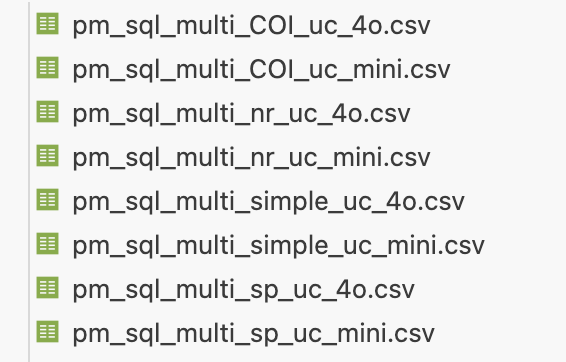


**'openai/gpt-4o', temperature=1, max_tokens=4096,**

- pm_sql_multi_sp (uc): score:174.8% ,time: 13m 38s Name: pm_sql_multi_sp_uc_4o_temp1

**Optimizated runs**

**'openai/gpt-4o', temperature=0.3, max_tokens=4096,**

- pm_sql_multi_sp (bootstrap_fewshot_1): score: 188.3% ,time: 8m 47s
settings: 8 bootstrapped demos, 2 rounds Name pm_sql_multi_sp_4o_bootstrap_fewshot_1

- pm_sql_multi_sp (bootstrap_fewshot_2 (removed col examples)): score: 183.5% ,time: 8m 30s
settings: 8 bootstrapped demos, 2 rounds (removed the column descriptions to save tokens)
Name pm_sql_multi_sp_4o_bootstrap_fewshot_2


- pm_sql_multi_sp (random_search_1 + Mipro (no real prompts adjusted)): score: 181.6% ,time: 
Name pm_sql_multi_sp_random_search_mipro_4o

**'openai/gpt-4o-mini', temperature=0.3, max_tokens=4096,**
- pm_sql_multi_sp (bootstrap_fewshot_1): score: 174.8% ,time: 13m 47s
settings: 8 bootstrapped demos, 2 rounds Name pm_sql_multi_sp_mini_bootstrap_fewshot_1

### PM_SQL_multi_sp (separate reasoning)

In [55]:
#gpt4T = dspy.LM(model='openai/gpt-4o', temperature=1, max_tokens=3000, stop=None, cache=False)

judge_adjusted = LM_EVAL(gpt4T)
judge_adjusted.load("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/judge_optimized_final.json")

sql_uncompiled = PM_SQL_multi_sp(pool=pool).activate_assertions()

In [110]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [109]:
zeroshot_optimized_program._compiled = True

In [111]:
score, outputs, scores = evaluate(program = zeroshot_optimized_program, return_all_scores= True)

Average Metric: 187.00 / 103 (181.6%): 100%|██████████| 103/103 [08:32<00:00,  4.98s/it]

2024/12/23 14:51:25 INFO dspy.evaluate.evaluate: Average Metric: 187 / 103 (181.6%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4141,✔️ [2]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,20930,


In [112]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results_SQL/compiled/pm_sql_multi_sp_random_search_mipro_4o", zeroshot_optimized_program, judge_adjusted)

In [58]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results/pm_sql_multi_sp_uc_4o_temp1", sql_uncompiled, judge_adjusted)

### PM_SQL_multi_nr (no reasoning)

In [35]:
gpt4T = dspy.LM(model='openai/gpt-4o', temperature=1, max_tokens=3000, stop=None, cache=True)

judge_adjusted = LM_EVAL(gpt4T)
judge_adjusted.load("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/judge_optimized_final.json")

sql_uncompiled = PM_SQL_multi_nr(pool=pool).activate_assertions()

In [36]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [37]:
score, outputs, scores = evaluate(program = sql_uncompiled, return_all_scores= True)

Average Metric: 173.00 / 103 (168.0%): 100%|██████████| 103/103 [04:13<00:00,  2.46s/it]

2024/12/20 13:30:23 INFO dspy.evaluate.evaluate: Average Metric: 173 / 103 (168.0%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4141,✔️ [2]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,20930,


In [38]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results/pm_sql_multi_nr_uc_4o", sql_uncompiled, judge_adjusted)

### PM_SQL_multi_COI (no reasoning)

In [40]:
#gpt4T = dspy.LM(model='openai/gpt-4o', temperature=1, max_tokens=3000, stop=None, cache=False)

judge_adjusted = LM_EVAL(gpt4T)
judge_adjusted.load("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/judge_optimized_final.json")

sql_uncompiled = PM_SQL_multi_COI(pool=pool).activate_assertions()

In [41]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [42]:
score, outputs, scores = evaluate(program = sql_uncompiled, return_all_scores= True)

Average Metric: 165.00 / 103 (160.2%): 100%|██████████| 103/103 [13:38<00:00,  7.95s/it]

2024/12/20 13:45:20 INFO dspy.evaluate.evaluate: Average Metric: 165 / 103 (160.2%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4141,✔️ [2]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,20930,


In [43]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results/pm_sql_multi_COI_uc_4o", sql_uncompiled, judge_adjusted)

### PM_SQL_simple (no reasoning, no prompts) - baseline

In [48]:
#gpt4T = dspy.LM(model='openai/gpt-4o', temperature=1, max_tokens=3000, stop=None, cache=False)

judge_adjusted = LM_EVAL(gpt4T)
judge_adjusted.load("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/judge_optimized_final.json")

sql_uncompiled = PM_SQL_multi_simple(pool=pool).activate_assertions()

In [49]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [ ]:
score, outputs, scores = evaluate(program = sql_uncompiled, return_all_scores= True)

In [51]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results/pm_sql_multi_simple_uc_4o", sql_uncompiled, judge_adjusted)

# Optimization

we select the architecture of PM_SQL_multi_sp since it scored the highest. Now we do further optimization:

BootstrapFewShot
BootstrapFewShotWithRandomSearch
MIPROV2

In [61]:
len(trainset)

78

## Bootstrap FewShot

In [65]:
print(len(trainset))

78


In [66]:
sql_uncompiled = PM_SQL_multi_sp(pool=pool).activate_assertions()

In [67]:
bootstrap_fewshot = BootstrapFewShot(
    metric = judge_adjusted,
    max_bootstrapped_demos = 8,
    max_labeled_demos = 0,
    max_rounds = 3,
    max_errors = 2)
sql_compiled = bootstrap_fewshot.compile(student = sql_uncompiled, trainset = trainset)

  1%|▏         | 1/78 [00:05<06:43,  5.23s/it]

trace is being used


  3%|▎         | 2/78 [00:09<05:42,  4.50s/it]

trace is being used


  4%|▍         | 3/78 [00:13<05:34,  4.46s/it]

trace is being used


  5%|▌         | 4/78 [00:18<05:54,  4.79s/it]

trace is being used


  6%|▋         | 5/78 [00:24<06:14,  5.14s/it]

trace is being used


  8%|▊         | 6/78 [00:30<06:14,  5.21s/it]

trace is being used


  9%|▉         | 7/78 [00:34<05:46,  4.87s/it]

trace is being used


 10%|█         | 8/78 [00:39<05:43,  4.90s/it]

trace is being used
Bootstrapped 8 full traces after 8 examples for up to 3 rounds, amounting to 8 attempts.


In [68]:
save_path = "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/sql_bootstrap_bootstrap_fewshot_1.json"
sql_compiled.save(path=save_path)

### Eval on testset

gpt 4-o

In [70]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [71]:
score, outputs, scores = evaluate(program = sql_compiled, return_all_scores= True)

Average Metric: 194.00 / 103 (188.3%): 100%|██████████| 103/103 [08:47<00:00,  5.12s/it]

2024/12/22 13:17:10 INFO dspy.evaluate.evaluate: Average Metric: 194 / 103 (188.3%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4141,✔️ [2]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,9383,✔️ [2]


In [74]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results_SQL/pm_sql_multi_sp_4o_bootstrap_fewshot_1", sql_compiled, judge_adjusted)

removing the column descriptions (bootstrap_fewshot_2.json)

In [78]:

sql_fewshot_2 = PM_SQL_multi_sp(pool=pool).activate_assertions()
sql_fewshot_2.load("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/sql_bootstrap_fewshot_2.json")

In [80]:
evaluate = Evaluate(devset=testset, metric=judge_adjusted, num_threads=5, display_progress=True, display_table=len(testset), return_outputs=True)

In [81]:
score, outputs, scores = evaluate(program = sql_fewshot_2, return_all_scores= True)

Average Metric: 189.00 / 103 (183.5%): 100%|██████████| 103/103 [08:33<00:00,  4.98s/it]

2024/12/22 13:46:00 INFO dspy.evaluate.evaluate: Average Metric: 189 / 103 (183.5%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4188,✔️ [1]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,20930,


In [82]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results_SQL/pm_sql_multi_sp_4o_bootstrap_fewshot_2", sql_fewshot_2, judge_adjusted)

gpt 4o-mini

In [75]:
score, outputs, scores = evaluate(program = sql_compiled, return_all_scores= True)

Average Metric: 40.00 / 26 (153.8%):  25%|██▌       | 26/103 [03:45<08:45,  6.82s/it]

2024/12/22 13:23:53 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "DISTINCT": syntax error


Average Metric: 74.00 / 47 (157.4%):  46%|████▌     | 47/103 [06:04<05:41,  6.11s/it]

2024/12/22 13:26:11 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "DISTINCT": syntax error


Average Metric: 180.00 / 103 (174.8%): 100%|██████████| 103/103 [12:40<00:00,  7.38s/it]

2024/12/22 13:32:42 INFO dspy.evaluate.evaluate: Average Metric: 180 / 103 (174.8%)


,question,example,answer,LM_EVAL
0,How many events are in the log?,561470,561470,✔️ [2]
1,When is the start of the event log?,1/1/2000 / 2000-01-01,2000-01-01 00:00:00+00:00,✔️ [2]
2,When is the end of the event log?,6/18/2013/ 2013-06-18,2013-06-18 00:00:00+00:00,✔️ [2]
3,How many cases have sent an appeal to the Prefecture?,4141,4188,✔️ [1]
4,How many event types are there?,11,11,✔️ [2]
...,...,...,...,...
98,Which case is underpaid == True AND part_paid == True AND payment_...,C23364,C23364,✔️ [2]
99,How many cases have undresolved == True AND obligation_topay_cance...,13395,13395,✔️ [2]
100,How many cases have unresolved == True AND obligation_topay_cancel...,2,6,
101,How many cases are credit collected before 2002-12-24?,9383,20930,


In [77]:
df_merged = save_report_v2(outputs,scores, "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Results_SQL/compiled/pm_sql_multi_sp_mini_bootstrap_fewshot_1", sql_compiled, judge_adjusted)

## BootStrap Random Search

In [86]:
sql_uncompiled = PM_SQL_multi_sp(pool=pool).activate_assertions()

In [88]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

fewshot_optimizer = BootstrapFewShotWithRandomSearch(metric=judge_adjusted, 
                                                     max_bootstrapped_demos=8, 
                                                     num_candidate_programs=8, 
                                                     max_labeled_demos=0,
                                                     num_threads=8)

sql_random_search = fewshot_optimizer.compile(student = sql_uncompiled,
                                               trainset=trainset, valset=trainset)

Going to sample between 1 and 8 traces per predictor.
Will attempt to bootstrap 8 candidate sets.
Average Metric: 120.00 / 76 (157.9%):  97%|█████████▋| 76/78 [05:48<00:12,  6.15s/it]

2024/12/22 15:30:21 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "'15 days'": syntax error
2024/12/22 15:30:27 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "15": syntax error


Average Metric: 122.00 / 78 (156.4%): 100%|██████████| 78/78 [06:12<00:00,  4.77s/it]

2024/12/22 15:30:40 INFO dspy.evaluate.evaluate: Average Metric: 122 / 78 (156.4%)



New best score: 156.41 for seed -3
Scores so far: [156.41]
Best score so far: 156.41
Average Metric: 119.00 / 74 (160.8%):  95%|█████████▍| 74/78 [05:36<00:20,  5.21s/it]

2024/12/22 15:36:20 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long


Average Metric: 123.00 / 76 (161.8%):  97%|█████████▋| 76/78 [05:52<00:12,  6.46s/it]

2024/12/22 15:36:37 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long


Average Metric: 123.00 / 77 (159.7%):  99%|█████████▊| 77/78 [06:03<00:07,  7.76s/it]

2024/12/22 15:36:48 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long


Average Metric: 125.00 / 78 (160.3%): 100%|██████████| 78/78 [06:13<00:00,  4.79s/it]

2024/12/22 15:36:54 INFO dspy.evaluate.evaluate: Average Metric: 125 / 78 (160.3%)



New best score: 160.26 for seed -2
Scores so far: [156.41, 160.26]
Best score so far: 160.26


  1%|▏         | 1/78 [00:02<03:20,  2.60s/it]

trace is being used


  3%|▎         | 2/78 [00:05<03:21,  2.65s/it]

trace is being used


  4%|▍         | 3/78 [00:08<03:41,  2.95s/it]

trace is being used


  5%|▌         | 4/78 [00:12<04:00,  3.24s/it]

trace is being used


  6%|▋         | 5/78 [00:16<04:30,  3.70s/it]

trace is being used


  8%|▊         | 6/78 [00:20<04:23,  3.65s/it]

trace is being used


  9%|▉         | 7/78 [00:23<04:18,  3.63s/it]

trace is being used


 10%|█         | 8/78 [00:27<04:17,  3.68s/it]

trace is being used


 12%|█▏        | 9/78 [00:31<04:09,  3.62s/it]

trace is being used


 13%|█▎        | 10/78 [00:35<04:01,  3.55s/it]


trace is being used
Bootstrapped 8 full traces after 10 examples for up to 1 rounds, amounting to 10 attempts.
Average Metric: 140.00 / 78 (179.5%): 100%|██████████| 78/78 [13:55<00:00, 10.71s/it]

2024/12/22 15:51:24 INFO dspy.evaluate.evaluate: Average Metric: 140 / 78 (179.5%)



New best score: 179.49 for seed -1
Scores so far: [156.41, 160.26, 179.49]
Best score so far: 179.49


  1%|▏         | 1/78 [00:04<06:17,  4.90s/it]

trace is being used


  3%|▎         | 2/78 [00:12<07:52,  6.22s/it]

trace is being used


  4%|▍         | 3/78 [00:18<07:57,  6.36s/it]

trace is being used


  5%|▌         | 4/78 [00:23<07:03,  5.72s/it]

trace is being used


  6%|▋         | 5/78 [00:29<07:17,  6.00s/it]

trace is being used


  8%|▊         | 6/78 [00:36<07:40,  6.39s/it]

trace is being used


  9%|▉         | 7/78 [00:43<07:32,  6.38s/it]

trace is being used


 10%|█         | 8/78 [00:48<06:51,  5.88s/it]

trace is being used


 12%|█▏        | 9/78 [00:59<08:44,  7.60s/it]

trace is being used


 13%|█▎        | 10/78 [01:03<07:10,  6.34s/it]


trace is being used
Bootstrapped 7 full traces after 10 examples for up to 1 rounds, amounting to 10 attempts.
Average Metric: 134.00 / 78 (171.8%): 100%|██████████| 78/78 [09:18<00:00,  7.16s/it]

2024/12/22 16:01:46 INFO dspy.evaluate.evaluate: Average Metric: 134 / 78 (171.8%)



Scores so far: [156.41, 160.26, 179.49, 171.79]
Best score so far: 179.49


  1%|▏         | 1/78 [00:04<05:12,  4.06s/it]

trace is being used


  3%|▎         | 2/78 [00:12<08:06,  6.40s/it]

trace is being used


  4%|▍         | 3/78 [00:15<06:37,  5.30s/it]


trace is being used
Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 134.00 / 76 (176.3%):  97%|█████████▋| 76/78 [07:06<00:12,  6.17s/it]

2024/12/22 16:09:13 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long
2024/12/22 16:09:19 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "15": syntax error


Average Metric: 138.00 / 78 (176.9%): 100%|██████████| 78/78 [07:32<00:00,  5.80s/it]

2024/12/22 16:09:34 INFO dspy.evaluate.evaluate: Average Metric: 138 / 78 (176.9%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92]
Best score so far: 179.49


  1%|▏         | 1/78 [00:03<04:58,  3.88s/it]


trace is being used
Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 120.00 / 78 (153.8%): 100%|██████████| 78/78 [06:12<00:00,  4.78s/it]

2024/12/22 16:15:51 INFO dspy.evaluate.evaluate: Average Metric: 120 / 78 (153.8%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85]
Best score so far: 179.49


  1%|▏         | 1/78 [00:02<03:49,  2.98s/it]

trace is being used


  3%|▎         | 2/78 [00:06<04:20,  3.43s/it]

trace is being used


  4%|▍         | 3/78 [00:16<07:39,  6.13s/it]

trace is being used


  5%|▌         | 4/78 [00:21<07:16,  5.90s/it]

trace is being used


  6%|▋         | 5/78 [00:26<06:55,  5.70s/it]

trace is being used


  8%|▊         | 6/78 [00:30<05:57,  4.97s/it]

trace is being used


  9%|▉         | 7/78 [00:36<06:18,  5.33s/it]

trace is being used


 10%|█         | 8/78 [00:43<06:16,  5.38s/it]


trace is being used
Bootstrapped 4 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
Average Metric: 133.00 / 78 (170.5%): 100%|██████████| 78/78 [07:13<00:00,  5.56s/it]

2024/12/22 16:23:48 INFO dspy.evaluate.evaluate: Average Metric: 133 / 78 (170.5%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85, 170.51]
Best score so far: 179.49


  1%|▏         | 1/78 [00:04<05:50,  4.55s/it]

trace is being used


  3%|▎         | 2/78 [00:10<06:53,  5.44s/it]

trace is being used


  4%|▍         | 3/78 [00:14<05:55,  4.74s/it]

trace is being used


  5%|▌         | 4/78 [00:19<06:01,  4.88s/it]

trace is being used


  6%|▋         | 5/78 [00:23<05:40,  4.67s/it]

trace is being used


  8%|▊         | 6/78 [00:26<04:54,  4.09s/it]

trace is being used


  9%|▉         | 7/78 [00:30<04:45,  4.03s/it]

trace is being used


 10%|█         | 8/78 [00:36<05:18,  4.55s/it]


trace is being used
Bootstrapped 4 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
Average Metric: 137.00 / 78 (175.6%): 100%|██████████| 78/78 [06:27<00:00,  4.97s/it]

2024/12/22 16:30:51 INFO dspy.evaluate.evaluate: Average Metric: 137 / 78 (175.6%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85, 170.51, 175.64]
Best score so far: 179.49


  1%|▏         | 1/78 [00:06<07:43,  6.02s/it]

trace is being used


  3%|▎         | 2/78 [00:10<06:17,  4.96s/it]

trace is being used


  4%|▍         | 3/78 [00:14<05:45,  4.60s/it]

trace is being used


2024/12/22 16:31:13 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long
  5%|▌         | 4/78 [00:27<09:38,  7.82s/it]

trace is being used


  6%|▋         | 5/78 [00:31<07:50,  6.44s/it]

trace is being used


  8%|▊         | 6/78 [00:34<06:34,  5.48s/it]

trace is being used


  9%|▉         | 7/78 [00:39<06:42,  5.67s/it]


trace is being used
Bootstrapped 5 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Average Metric: 138.00 / 78 (176.9%): 100%|██████████| 78/78 [08:04<00:00,  6.22s/it]

2024/12/22 16:39:36 INFO dspy.evaluate.evaluate: Average Metric: 138 / 78 (176.9%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85, 170.51, 175.64, 176.92]
Best score so far: 179.49


  1%|▏         | 1/78 [00:03<05:04,  3.96s/it]

trace is being used


  3%|▎         | 2/78 [00:10<06:54,  5.46s/it]


trace is being used
Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 124.00 / 76 (163.2%):  97%|█████████▋| 76/78 [06:26<00:10,  5.25s/it]

2024/12/22 16:46:23 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "'15 days'": syntax error


Average Metric: 126.00 / 78 (161.5%): 100%|██████████| 78/78 [06:51<00:00,  5.27s/it]

2024/12/22 16:46:38 INFO dspy.evaluate.evaluate: Average Metric: 126 / 78 (161.5%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85, 170.51, 175.64, 176.92, 161.54]
Best score so far: 179.49


  1%|▏         | 1/78 [00:04<05:31,  4.30s/it]

trace is being used


  3%|▎         | 2/78 [00:07<04:25,  3.50s/it]

trace is being used


2024/12/22 16:46:50 INFO dspy.primitives.assertions: SuggestionFailed: Your reasoning should be fewer than 1400 characters long
  4%|▍         | 3/78 [00:18<09:03,  7.24s/it]

trace is being used


  5%|▌         | 4/78 [00:22<07:13,  5.86s/it]

trace is being used


  6%|▋         | 5/78 [00:28<07:12,  5.92s/it]

trace is being used


  8%|▊         | 6/78 [00:32<06:20,  5.29s/it]

trace is being used


  9%|▉         | 7/78 [00:37<06:17,  5.32s/it]


trace is being used
Bootstrapped 6 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Average Metric: 128.00 / 78 (164.1%): 100%|██████████| 78/78 [06:49<00:00,  5.25s/it]

2024/12/22 16:54:05 INFO dspy.evaluate.evaluate: Average Metric: 128 / 78 (164.1%)



Scores so far: [156.41, 160.26, 179.49, 171.79, 176.92, 153.85, 170.51, 175.64, 176.92, 161.54, 164.1]
Best score so far: 179.49
11 candidate programs found.


In [89]:
save_path = "/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/sql_random_search_3.json"
sql_random_search.save(path=save_path)

In [95]:
sql_random_search._compiled = False

In [99]:
from dspy.teleprompt import MIPROv2

teleprompter = MIPROv2(
    metric=judge_adjusted,
    verbose=True,
    max_bootstrapped_demos = 0,
    max_labeled_demos = 0,
    auto="light", # Can choose between light, medium, and heavy optimization runs
)

In [100]:
zeroshot_optimized_program = teleprompter.compile(
    sql_random_search,
    trainset=trainset,
    max_bootstrapped_demos=0, # ZERO FEW-SHOT EXAMPLES
    max_labeled_demos=0, # ZERO FEW-SHOT EXAMPLES
    requires_permission_to_run=False,
)

2024/12/23 12:13:49 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: True
num_candidates: 4
valset size: 62

2024/12/23 12:13:49 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2024/12/23 12:13:49 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2024/12/23 12:13:49 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=4 sets of demonstrations...


Bootstrapping set 1/4
Bootstrapping set 2/4


  6%|▋         | 1/16 [00:06<01:31,  6.10s/it]

trace is being used


 12%|█▎        | 2/16 [00:15<01:54,  8.18s/it]

trace is being used


 19%|█▉        | 3/16 [00:20<01:29,  6.92s/it]


trace is being used
Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 3/4


  6%|▋         | 1/16 [00:04<01:10,  4.69s/it]

trace is being used


 12%|█▎        | 2/16 [00:09<01:05,  4.70s/it]

trace is being used


 19%|█▉        | 3/16 [00:15<01:05,  5.01s/it]


trace is being used
Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 4/4


  6%|▋         | 1/16 [00:05<01:27,  5.82s/it]

trace is being used


 12%|█▎        | 2/16 [00:11<01:23,  5.97s/it]

trace is being used


 19%|█▉        | 3/16 [00:17<01:15,  5.80s/it]
2024/12/23 12:14:42 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2024/12/23 12:14:42 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


trace is being used
Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Error getting source code: unhashable type: 'CodeOutput'.

Running without program aware proposer.


2024/12/23 12:14:53 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



DATA SUMMARY: The dataset captures detailed logs of events related to cases involving fines and penalties, emphasizing statistical analysis through counts, averages, and frequencies of events such as "Create Fine," "Send Appeal to Prefecture," and "Payment." Its well-structured questions indicate a focus on precise event tracking, potentially supporting automated reporting to enhance administrative efficiency. The large volume of records and use of comparative metrics suggest its utility in improving process optimization for case management systems.
Using a randomly generated configuration for our grounded proposer.
Selected tip: simple
task_demos 




[2024-12-23T12:14:56.186999]

System message:

Your input fields are:
1. `dataset_description` (str): A description of the dataset that we are using.
2. `task_demos` (str): Example inputs/outputs of our module.
3. `basic_instruction` (str): Basic instruction.
4. `tip` (str): A suggestion for how to go about generating the new instruction

2024/12/23 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2024/12/23 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate a single SQLite query that returns the specific information requested in the question 
and include relevant details such as duration or amount. When asked about information pertaining 
to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context.

2024/12/23 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a data analyst tasked with generating a single SQLite query to extract precise information from a detailed





[2024-12-23T12:15:45.357817]

System message:

Your input fields are:
1. `dataset_description` (str): A description of the dataset that we are using.
2. `task_demos` (str): Example inputs/outputs of our module.
3. `basic_instruction` (str): Basic instruction.

Your output fields are:
1. `proposed_instruction` (str): Propose an instruction that will be used to prompt a Language Model to perform this task.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## dataset_description ## ]]
{dataset_description}

[[ ## task_demos ## ]]
{task_demos}

[[ ## basic_instruction ## ]]
{basic_instruction}

[[ ## proposed_instruction ## ]]
{proposed_instruction}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.


User

2024/12/23 12:23:27 INFO dspy.evaluate.evaluate: Average Metric: 110 / 62 (177.4%)
2024/12/23 12:23:27 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 177.42

2024/12/23 12:23:27 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2024/12/23 12:23:27 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/dspy_v2/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2024/12/23 12:23:27 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 1 / 7 ==
2024/12/23 12:23:27 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a data analyst tasked with generating a single SQLite query to extract precise information from a detailed event log database concerning cases involving fines and penalties. Your goal is to construct a query that returns the specific information requested in the question, such as counts, averages, or frequencies of events like "Create Fine" or "Payment." Ensure that when questions pertain to cases, you group by the case identifier to avoid counting the same case multiple times. Use aggregation functions and subqueries as needed to provide a concise and direct answer, and include additional relevant details like duration or amount. Be cautious to distinguish between questions about cases and those about events to avoid using aggregated columns incorrectly.
p: Sqlite Query:
Predictor 1
i: To create an SQLite query that addresses a specific question about the event log dataset, follow these steps: 

1. **Understand the Question Context**: Determine whether the ques

2024/12/23 12:26:30 INFO dspy.evaluate.evaluate: Average Metric: 40 / 25 (160.0%)
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 160.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 1: Instruction 2', 'Predictor 2: Instruction 3'].
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0]
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 2 / 7 ==
2024/12/23 12:26:30 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Generate a single SQLite query that returns the specific information requested in the question 
and include relevant details such as duration or amount. When asked about information pertaining 
to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context.
p: Sqlite Query:
Predictor 1
i: Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
Database Information: Use the details about the database and its columns to guide your approach. 
Be specific about whether the question pertains to "cases" or "events," since every row is 

2024/12/23 12:29:30 INFO dspy.evaluate.evaluate: Average Metric: 46 / 25 (184.0%)
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 184.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 1: Instruction 0', 'Predictor 2: Instruction 2'].
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0]
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 3 / 7 ==
2024/12/23 12:29:30 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Imagine you are tasked with generating a critical report for the city's administrative body to assess the efficiency of their case management system. Your goal is to write a precise SQLite query that extracts specific information from the event log database. This query must accurately differentiate between case-related and event-related questions, ensuring that aggregated data is grouped appropriately to prevent misinterpretation. Your report will influence key decisions on process optimization, so it is essential to ensure the accuracy and reliability of the data you provide. Use subqueries and outer queries effectively to handle complex data retrieval, and always keep in mind the distinction between cases and events to avoid skewing the results.
p: Sqlite Query:
Predictor 1
i: You are a data analyst tasked with optimizing the efficiency of case management systems by analyzing event logs related to fines and penalties. Your goal is to develop a strategy and logic to cr

2024/12/23 12:32:29 INFO dspy.evaluate.evaluate: Average Metric: 45 / 25 (180.0%)
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 180.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 1: Instruction 1', 'Predictor 2: Instruction 0'].
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0, 180.0]
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 4 / 7 ==
2024/12/23 12:32:29 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Generate a single SQLite query that returns the specific information requested in the question 
and include relevant details such as duration or amount. When asked about information pertaining 
to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context.
p: Sqlite Query:
Predictor 1
i: Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
Database Information: Use the details about the database and its columns to guide your approach. 
Be specific about whether the question pertains to "cases" or "events," since every row is 

2024/12/23 12:35:30 INFO dspy.evaluate.evaluate: Average Metric: 48 / 25 (192.0%)
2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 192.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 1: Instruction 0', 'Predictor 2: Instruction 0'].
2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0, 180.0, 192.0]
2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:35:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 5 / 7 ==
2024/12/23 12:35:31 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Generate a single SQLite query that returns the specific information requested in the question 
and include relevant details such as duration or amount. When asked about information pertaining 
to cases (not events), group by case to avoid counting the same case multiple times. Aggregate when necessary,
using subqueries and outer queries to limit the output size and results in a table that answers the question directly.
Be aware to make a distinction between questions that ask about cases and question that ask about events, since some of the available columns are aggregated over cases and might lead to wrong results when used in the wrong context.
p: Sqlite Query:
Predictor 1
i: Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
Database Information: Use the details about the database and its columns to guide your approach. 
Be specific about whether the question pertains to "cases" or "events," since every row is 

2024/12/23 12:38:19 INFO dspy.evaluate.evaluate: Average Metric: 43 / 25 (172.0%)
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 172.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 1: Instruction 0', 'Predictor 2: Instruction 0'].
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0, 180.0, 192.0, 172.0]
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 6 / 7 ==
2024/12/23 12:38:20 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Imagine you are tasked with generating a critical report for the city's administrative body to assess the efficiency of their case management system. Your goal is to write a precise SQLite query that extracts specific information from the event log database. This query must accurately differentiate between case-related and event-related questions, ensuring that aggregated data is grouped appropriately to prevent misinterpretation. Your report will influence key decisions on process optimization, so it is essential to ensure the accuracy and reliability of the data you provide. Use subqueries and outer queries effectively to handle complex data retrieval, and always keep in mind the distinction between cases and events to avoid skewing the results.
p: Sqlite Query:
Predictor 1
i: Objective: Develop a strategy and logic to create a single SQLite query that will answer a given question.
Database Information: Use the details about the database and its columns to guide your 

2024/12/23 12:41:05 INFO dspy.evaluate.evaluate: Average Metric: 42 / 25 (168.0%)
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 168.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 1: Instruction 0', 'Predictor 2: Instruction 2'].
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0, 180.0, 192.0, 172.0, 168.0]
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 7 / 7 ==
2024/12/23 12:41:05 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: Create a SQLite query that accurately retrieves the requested information from the dataset, ensuring to differentiate between case-level and event-level inquiries. When the question pertains to cases, group the results by 'case_concept_name' to prevent duplicate counting of cases. Utilize appropriate SQL functions such as COUNT, AVG, or others as needed for aggregation. If the query involves calculating averages or totals, consider using subqueries or outer queries to refine the output and ensure it directly addresses the question. Always verify the context of the question to select the right columns and avoid misinterpretation of aggregated data.
p: Sqlite Query:
Predictor 1
i: You are a data analyst tasked with optimizing the efficiency of case management systems by analyzing event logs related to fines and penalties. Your goal is to develop a strategy and logic to create a single SQLite query that will answer a given question about these events. Use the detailed info

2024/12/23 12:45:36 INFO dspy.evaluate.evaluate: Average Metric: 43 / 25 (172.0%)
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 172.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 1: Instruction 1', 'Predictor 2: Instruction 3'].
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [160.0, 184.0, 180.0, 192.0, 172.0, 168.0, 172.0]
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42]
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: ===========================


2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 1 =====
2024/12/23 12:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 184.0) from minibatch trials...



Average Metric: 30.00 / 16 (187.5%):  26%|██▌       | 16/62 [01:45<04:56,  6.45s/it]

2024/12/23 12:47:29 INFO dspy.primitives.assertions: SuggestionFailed: Error executing SQLite query near "15": syntax error


Average Metric: 110.00 / 62 (177.4%): 100%|██████████| 62/62 [07:07<00:00,  6.90s/it]

2024/12/23 12:52:44 INFO dspy.evaluate.evaluate: Average Metric: 110 / 62 (177.4%)
2024/12/23 12:52:44 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [177.42, 177.42]
2024/12/23 12:52:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 177.42
2024/12/23 12:52:44 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2024/12/23 12:52:44 INFO dspy.teleprompt.mipro_optimizer_v2: 

2024/12/23 12:52:44 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 177.42!


In [106]:
zeroshot_optimized_program.save("/Users/sulzair/Documents/Bachelor Thesis/dspy_v2/Optimized_prompts/sql_mipro_v2_1_optimized.json")